### Import Libraries

In [ ]:
import numpy as np
from umap import UMAP
import tensorflow as tf
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

### Import Dataset

In [ ]:
(trainX, trainY), test = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Preprocess Data

In [ ]:
def preprocess(images, batch_size = 500):
  resized = []
  for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    print(batch[0].shape)
    batch = tf.expand_dims(batch, -1)
    print(batch[0].shape)
    batch = tf.image.resize(batch, (224, 224))
    print(batch[0].shape)
    batch = tf.image.grayscale_to_rgb(batch)
    print(batch[0].shape)
    resized.append(batch)
    print('-'*10)
  return tf.concat(resized, axis=0).numpy()

In [ ]:
X_train = preprocess(trainX[:2000])
Y_train = to_categorical(trainY[:2000])

(28, 28)
(28, 28, 1)
(224, 224, 1)
(224, 224, 3)
----------
(28, 28)
(28, 28, 1)
(224, 224, 1)
(224, 224, 3)
----------
(28, 28)
(28, 28, 1)
(224, 224, 1)
(224, 224, 3)
----------
(28, 28)
(28, 28, 1)
(224, 224, 1)
(224, 224, 3)
----------


In [ ]:
print(X_train.shape, Y_train.shape)

(2000, 224, 224, 3) (2000, 10)


### Load VGG16 Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Compile and Train

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=64, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 544ms/step - accuracy: 0.3605 - loss: 3.5612
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.9280 - loss: 0.2744
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.9781 - loss: 0.0819
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.9873 - loss: 0.0345
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.9956 - loss: 0.0145


### Extract Features

In [ ]:
feature_extractor_before = Model(base_model.input, Flatten()(base_model.output))
feature_extractor_after = Model(model.input, model.layers[-2].output)


features_before = feature_extractor_before.predict(X_train)
features_after = feature_extractor_after.predict(X_train)

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step


### Plotter

In [ ]:
def plot_2d(features, labels, title = None):
  plt.figure(figsize=(10, 5))
  scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', s=10)
  plt.legend(*scatter.legend_elements(), title="Digit", bbox_to_anchor=(1.05, 1))
  plt.title(title)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

### Dimension Reducers

In [ ]:
reducers = {
    'PCA': PCA(n_components=2),
    'TSNE': TSNE(n_components=2),
    'UMAP': UMAP(n_components=2)
}

### Plotting

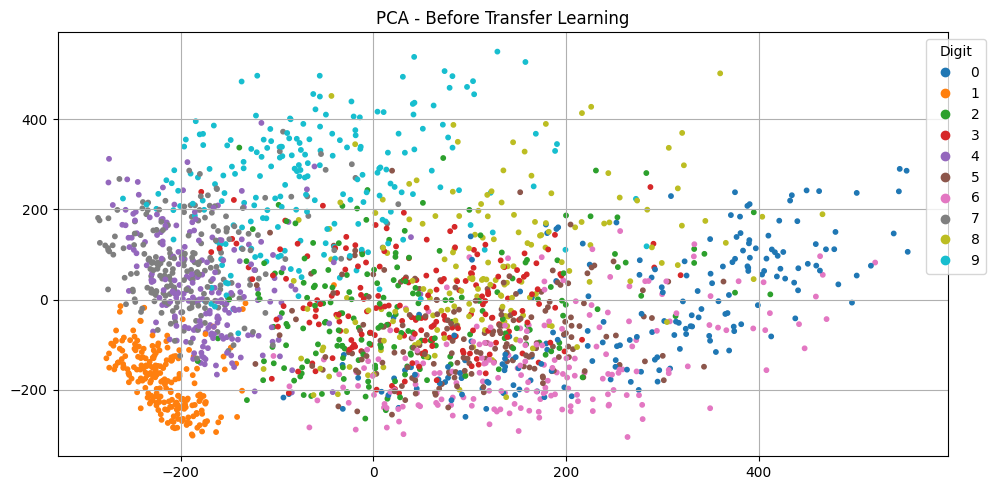

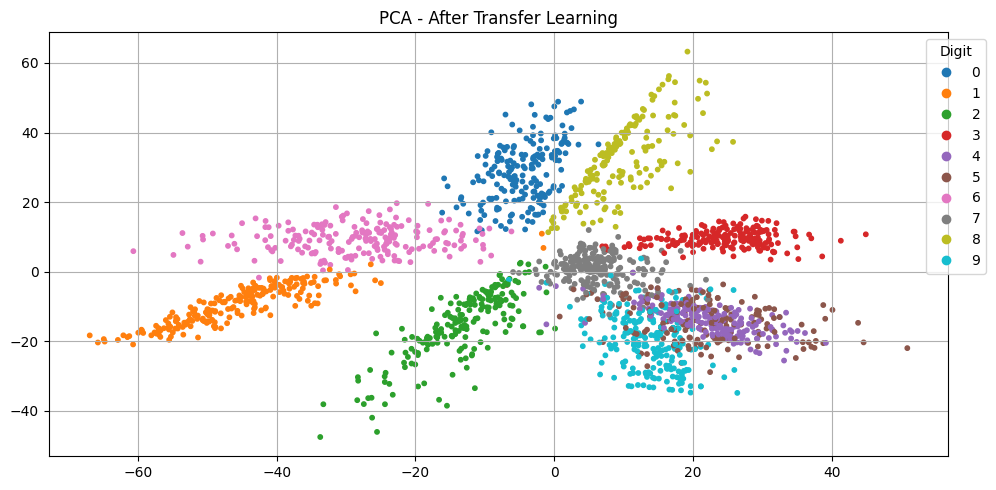

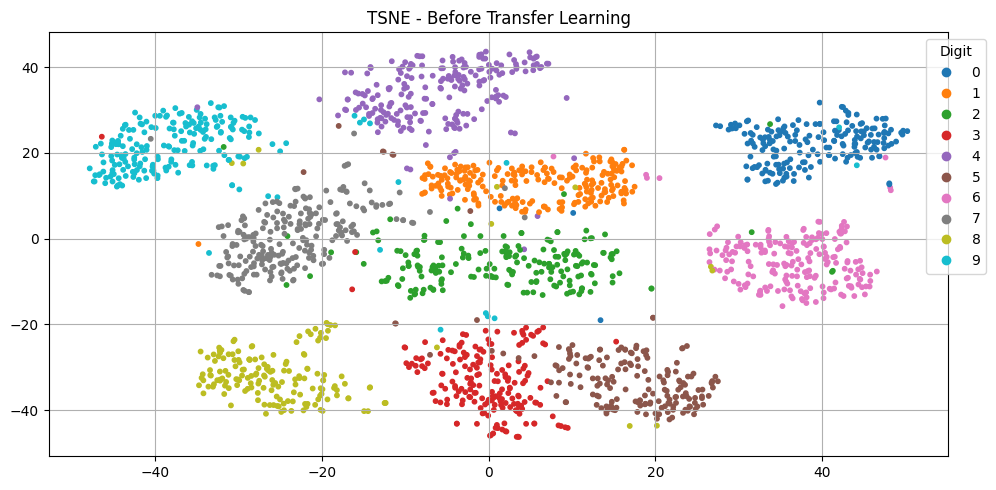

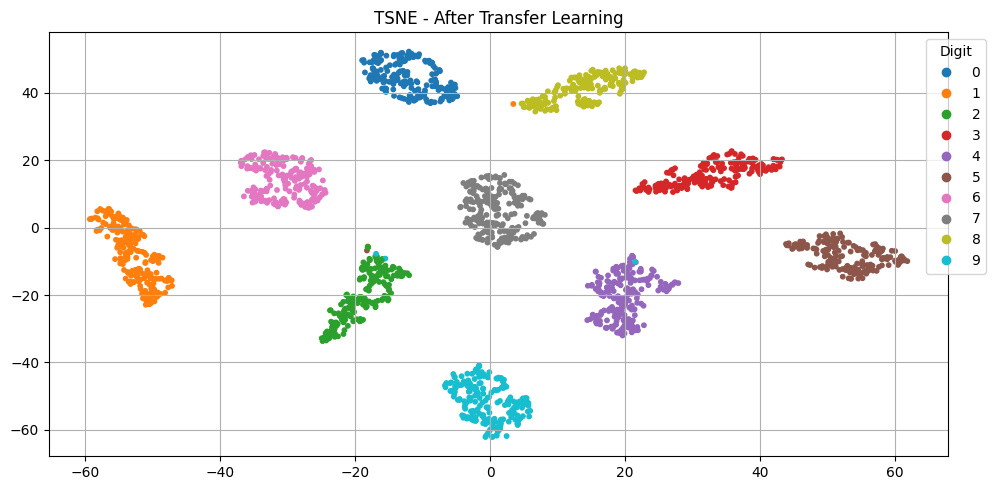

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


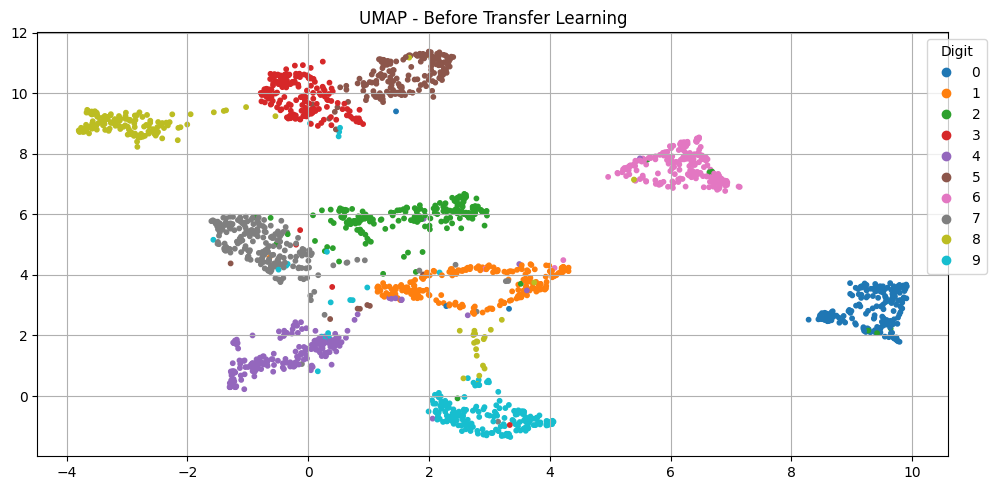

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


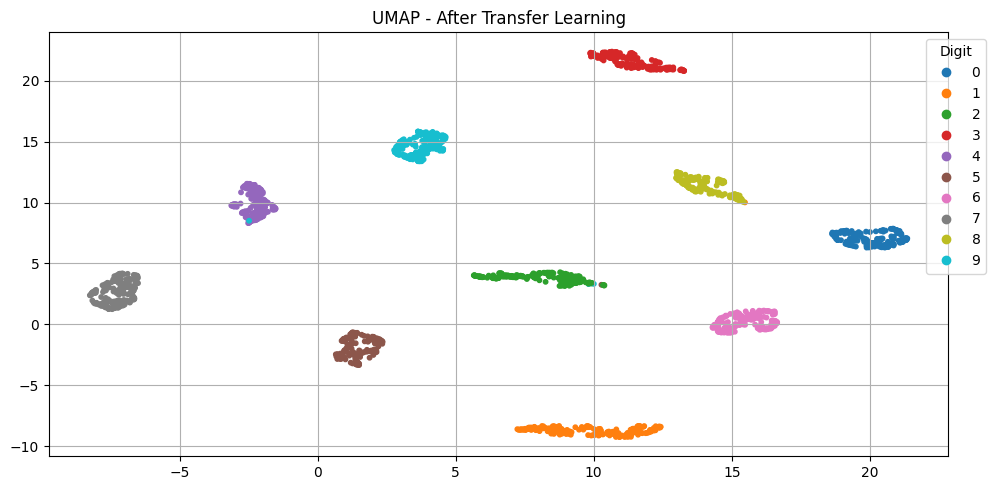

In [ ]:
for name, reducer in reducers.items():
    reduced_before = reducer.fit_transform(features_before)
    plot_2d(reduced_before, trainY[:2000], f"{name} - Before Transfer Learning")

    reduced_after = reducer.fit_transform(features_after)
    plot_2d(reduced_after, trainY[:2000], f"{name} - After Transfer Learning")